# Phospho-peptide Analysis for MSGF+ search results on cyano_dataset_2016118

In [1]:
import numpy
import pandas, numpy, csv, re
from cStringIO import StringIO
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sb
import matplotlib.patches as mpatches
from pyteomics import fasta
import collections
import scipy.stats as stats

Read peptide x sample consensus feature map  
Note, for this phospho-peptide analysis I am NOT using DeMixQ    
The FDR-filtered use of EIC-extracted signals to fill consensus missing values does not seem to be working very well   
In addition, the correlation between feature intensity and EIC intensities is not good either. In my_DeMixQ_data_processing, if pearsons r2 between those is lower than .5 I remove the map. In the phospho data that would leave out 6 out of 12 maps!  
At least, the particular case of protein PII (ssl0707), phosphorylated at S(49) is not bad, if I look for YRGS(Phospho)EYTVEFLQK in the consensus map I see a feature is found in all maps with a quality_cf of 0.741575 at RT_cf 4793.256863 and mz_cf 850.390625


In [2]:
consensus_txt = "/home/vitalv/cyano_dataset_20161118/label-free-demixq-diffacto-phosphorylation/textExporter/consensusMap.csv"
num_samples = 4
num_replica = 3

def read_consensus(fn):
	'''
	Read text table from consensusXML exported by OpenMS TextExporter
	'''
	cons_header = []
	pept_header = []
	runs_name = []

	# fetch the headers for consensus features, unassigned peptides and experiments' names. 
	for row in csv.reader(open(fn), delimiter='\t'):
		if row[0] == '#CONSENSUS':
			cons_header = row
		elif row[0] == '#UNASSIGNEDPEPTIDE':
			pept_header = row
		elif row[0] == 'MAP':
			#runs_name.append(row[2])
			runs_name.append(row[2].split("/")[-1].split(".")[0])

	# read consensus features
	s = StringIO()
	with open(fn) as fh:
		for line in fh:
			if line.startswith("CONSENSUS"):
				s.write(line)
	s.seek(0)
	cons = pandas.read_csv(s, sep='\t', header=None, names=cons_header)
	co_peps = []
	with open(fn) as fh:
		for line in fh:
			if line.startswith("CONSENSUS"):
				co_peps.append('')
			elif line.startswith('PEPTIDE') and co_peps[-1] == '':
				# choose the first recorded peptide sequence as consensus sequence
				co_peps[-1] = line.split("\t")[5]
	cons['peptide_0'] = co_peps
	
	# read uassigned peptides as consensus features
	s = StringIO()
	with open(fn) as fh:
		for line in fh:
			if line.startswith("UNASSIGNEDPEPTIDE"):
				s.write(line)
	s.seek(0)
	ua_peps = pandas.read_csv(s, sep='\t', header=None, names=pept_header)
	ua_peps = ua_peps.groupby(['sequence', 'charge']).mean()
	
	return cons, ua_peps, runs_name

In [3]:
cons, uapep, ic0 = read_consensus(consensus_txt)
ic0 = sorted(ic0)
icols = [i for i in cons.columns if i.startswith('intensity_')]
cons = cons[icols + ['quality_cf', 'peptide_0', 'charge_cf', 'rt_cf', 'mz_cf']]
cons.rename(columns=dict(zip(icols[1:], ic0)), inplace=True)
feature_cols = [c for c in cons.columns if "_GM_" in c]

#### Filter out peptides that have not been detected in at least one of the replicates for all 4 samples/conditions

In [4]:
for i in numpy.array(feature_cols).reshape(num_samples, num_replica):
	sample = i[0].split("_GM_")[1].split("_")[0]
	cons["detected_in_%s"%sample] = cons[i].sum(axis=1).notnull() #the sum will only be null if all 3 replicates per i(i is 3ReplicatesOfEachCondition) are Nan
detected_cols = [c for c in cons.columns if "detected" in c]
cons = cons[cons[detected_cols].sum(axis=1) == 4]
cons = cons[cons.peptide_0 != '']
cons["base_seq"] = cons.peptide_0.str.replace('\(Phospho\)|\(Oxidation\)|\(Carbamidomethyl\)', '')

#### Get a new df just for the phosphopeptides

In [5]:
phospho_peptides = cons[cons.peptide_0.str.contains("Phosph")]
phospho_peptides_groups = phospho_peptides.groupby('base_seq', group_keys=False)
phospho_peptides = phospho_peptides_groups.apply(lambda x: x.ix[x.quality_cf.idxmax()])

#### Get list of proteins for the phosphopeptides and for all peptides

In [6]:
db = "/home/vitalv/database/Synechocystis_PCC6803_protein_sequences.fasta"
phospho_pep_prot_dict = {}
all_pep_prot_dict = {}
for pep in phospho_peptides.base_seq:
	for header, seq, in fasta.read(db):
		if pep in seq:
			phospho_pep_prot_dict[pep] = header.split(" ")[0]

phospho_pep_prot_dict = collections.OrderedDict(sorted(phospho_pep_prot_dict.items()))
phospho_peptides["protein"] = phospho_pep_prot_dict.values()

for pep in list(set(cons["base_seq"])):
	for header, seq, in fasta.read(db):
		if pep in seq:
			all_pep_prot_dict[pep] = header.split(" ")[0]
            
#I will need the protein next to each peptide for the abundance plots
cons["protein"] = pandas.Series()
for i, row in cons.iterrows():
	if cons.ix[i].base_seq in all_pep_prot_dict.keys():
		cons.loc[i, 'protein'] = all_pep_prot_dict[cons.ix[i].base_seq]
	else:
		cons.loc[i, 'protein'] = ""

### Frequency S / T / Y position of the phosphorylation


In [7]:
import re
phospho_residues = []
a = list(phospho_peptides.peptide_0)
p = re.compile("\(Phospho\)")
for pep in a:
	for match in p.finditer(pep):
		phospho_residue_ix = match.start()-1
		phospho_residues += pep[phospho_residue_ix]

residue_frequency = collections.Counter(phospho_residues)
print residue_frequency

Counter({'T': 27, 'Y': 23, 'S': 21})


#### Count number of phosphorylation sites, phosphopeptides, phosphoproteins. See proteins containing > 1 phosphopeptides

In [8]:
#Number of phosphopeptides:
print "Number of phosphopeptides: %s"%len(set(phospho_peptides.peptide_0))

#Number of phosphorylation sites
print "Number of phosphorylation sites: %s"% len(phospho_residues)

#Number of phosho-proteins
print "Number of phosphoproteins: %s"%  len(set(phospho_peptides["protein"])) 

print ""

#proteins having > 1 phosphopeptide 
collections.Counter(phospho_peptides["protein"]) # ssr0692:2;  sll0726:2;  slr2058:2

for p in ["ssr0692", "slr2058", "sll0726"]:
	print p
	print phospho_peptides[phospho_peptides["protein"] == p].peptide_0 
	print "\n"


Number of phosphopeptides: 62
Number of phosphorylation sites: 71
Number of phosphoproteins: 59

ssr0692
base_seq
KRVLTQTAIAHK          KRVLT(Phospho)QTAIAHK
RVLTQTAIAHKETLR    RVLTQTAIAHKET(Phospho)LR
Name: peptide_0, dtype: object


slr2058
base_seq
KTSRKKATTTAKGTKKTTSKK    KT(Phospho)SRKKATTTAKGTKKTT(Phospho)SKK
TSRKKATTTAKGTK                  T(Phospho)SRKKATTTAKGT(Phospho)K
Name: peptide_0, dtype: object


sll0726
base_seq
EGLADGIIITPSHNPPTDGGFK    EGLADGIIITPS(Phospho)HNPPTDGGFK
QQWSGLSAIGKTLVSSSMIDR      QQWSGLSAIGKTLVSSS(Phospho)MIDR
Name: peptide_0, dtype: object




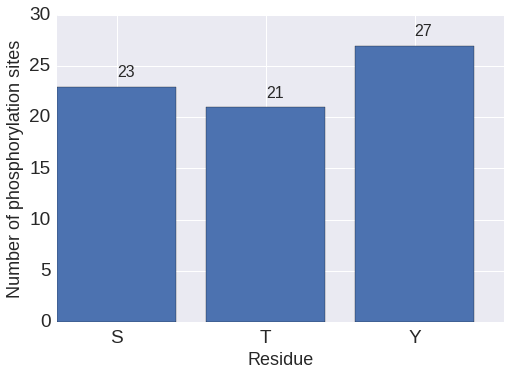

In [9]:
rects = plt.bar([1,2,3], residue_frequency.values())
bar_width = 0.8
bar_l = [i+1 for i in range(3)] # positions of the left bar-boundaries
tick_pos = [i+(bar_width/2) for i in bar_l] # positions of the x-axis ticks (center of the bars as bar labels)
plt.ylabel("Number of phosphorylation sites", fontsize=18)
plt.yticks(fontsize=19)
plt.xlabel("Residue", fontsize=18)
plt.title("", fontsize=18)
plt.xticks(tick_pos, ["S", "T", "Y"], fontsize=19)
#plt.text(tick_pos, [f + 1 for f in residue_frequency.values()], residue_frequency.values())
for t in range(len(tick_pos)): 
	plt.text(tick_pos[t], residue_frequency.values()[t]+1, residue_frequency.values()[t], fontsize=16)

### Functions of the proteins that phoshpopeptides belong to (Compared to total genome)

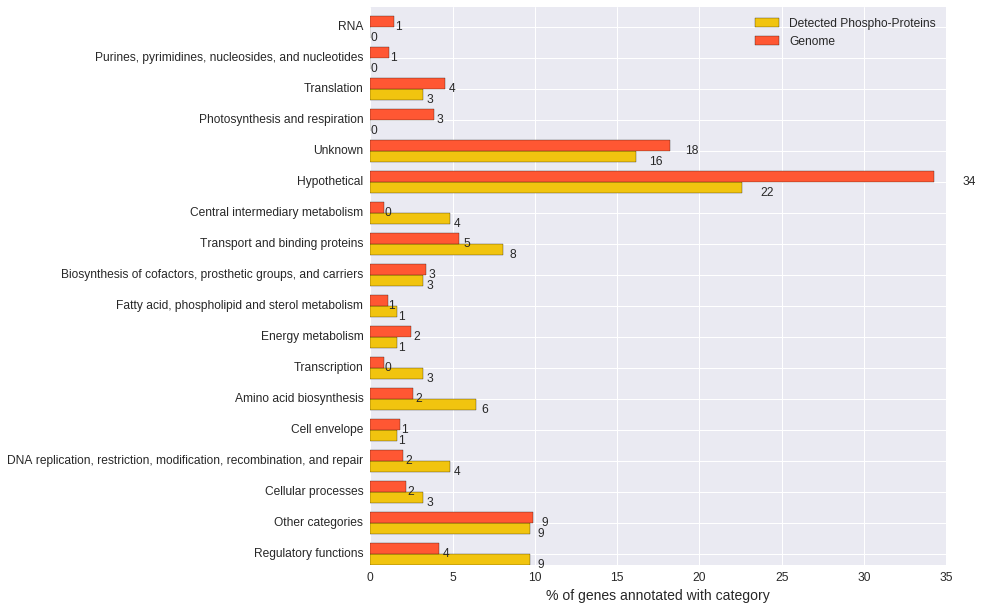

In [10]:
category_f = "/home/vitalv/cyano_dataset_20161118/category.txt"
category_df = pandas.read_csv(category_f, delimiter="\t", header=None)
category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
cols = ["geneID", "definition", "first_category_name", "second_category_name"]
phospho_peptides = pandas.merge(phospho_peptides, category_df[cols], left_on='protein', right_on='geneID', how='left')

category_data_genome = category_df.groupby("first_category_name").size().to_dict()
category_data_genome_percent = {}
for cat, num in category_data_genome.items():
	category_data_genome_percent[cat] = round(float(num)/sum(category_data_genome.values()) * 100,2)

category_data_phosphoset = phospho_peptides.groupby("first_category_name").size().to_dict()
category_data_phosphoset_percent = {}
for cat, num in category_data_phosphoset.items():
	category_data_phosphoset_percent[cat] = round(float(num)/sum(category_data_phosphoset.values()) * 100,2)

_categories = [cat for cat in category_data_genome_percent.keys() if cat not in category_data_phosphoset_percent.keys()]
for c in _categories:
	category_data_phosphoset_percent[c] = 0


def autolabel_width(rects):
	# attach text label with bar height in barplot
	for rect in rects:
		width = rect.get_width()
		ax.text(1.05*width, rect.get_y()-(rect.get_height()/2.), int(width),  ha='left', va='bottom', size=12)


ind = numpy.arange(len(category_data_phosphoset_percent))  
width = 0.35# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,10))
categories_phospho, categories_genome = [], []
tick_labels = []
for cat, num in category_data_genome_percent.items():
	categories_phospho.append(category_data_phosphoset_percent[cat])
	categories_genome.append(category_data_genome_percent[cat])
	tick_labels.append(cat)
rects1 = ax.barh(ind, categories_phospho, width, color='#F1C40F')
rects2 = ax.barh(ind + width, categories_genome, width, color='#FF5733')
ax.set_xlabel("% of genes annotated with category", fontsize=14)
ax.set_xticklabels(range(0,40,5), fontsize=12)
ax.set_yticks(ind + width)
ax.set_yticklabels(tick_labels, fontsize="12")
ax.legend((rects1[0], rects2[0]), ('Detected Phospho-Proteins', 'Genome'), fontsize=12)
autolabel_width(rects1)
autolabel_width(rects2)
plt.gcf().subplots_adjust(left=0.4)
plt.show()

### Functional annotation Enrichment of phosphoproteins

In [11]:
background_genes = list(set(all_pep_prot_dict.values()))
genes = list(phospho_peptides["protein"])

def enrich(input_gene_list, background_gene_list):

	category_f = "/home/vitalv/cyano_dataset_20161118/category.txt"
	category_df = pandas.read_csv(category_f, delimiter="\t", header=None, names=["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"])
	data = category_df[category_df["geneID"].isin(input_gene_list)]
	background = category_df[category_df["geneID"].isin(background_gene_list)]
	print "first_category_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + "\t" + "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value"
	for category in data.first_category_name.unique():
		k = len(data) #input list (list of differentially abundant proteins -ANOVA<0.05-)
		x = len(data[data.first_category_name == category]) #num of genes in the input list with the annotation
		N = len(set(background_gene_list)) #background number of genes. One could use the whole genome OR better yet, the set of detected (over a certain threshold) proteins
		m = len(background[background.first_category_name == category])
		p = stats.hypergeom.sf(x, N, k, m)
		print category + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p)

enrich(genes, background_genes)


first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Amino acid biosynthesis	4	59	81	1961	0.0931746337069
Biosynthesis of cofactors, prosthetic groups, and carriers	2	59	82	1961	0.452002445098
Cell envelope	1	59	49	1961	0.43788822955
Cellular processes	2	59	60	1961	0.268966897375
Central intermediary metabolism	2	59	23	1961	0.0298728914829
Energy metabolism	1	59	77	1961	0.683512302211
Fatty acid, phospholipid and sterol metabolism	1	59	27	1961	0.194015547632
Regulatory functions	6	59	89	1961	0.0155410772517
DNA replication, restriction, modification, recombination, and repair	2	59	40	1961	0.116716375802
Transcription	2	59	22	1961	0.0265332025578
Translation	2	59	154	1961	0.855979831151
Transport and binding proteins	5	59	83	1961	0.0358288517955
Other categories	6	59	149	1961	0.155819101267
Hypothetical	13	59	621	1961	0.93278159902
Unknown	10	59	270	1961	0.178548063115


### Protein PII. ssl0707
tryptic_peptides = ["VEAIIRPFK", "IALVNAGIVGMTVSEVR", "IEIVVDEGQVDMVVDK", "IFISPVDSVVR", "YRGSEYTVEFLQK", "YRGS(Phospho)EYTVEFLQK", "GSEYTVEFLQK", "GS(Phospho)EYTVEFLQK"]

In [12]:
peptides = ["VEAIIRPFK", "IALVNAGIVGMTVSEVR", "IEIVVDEGQVDMVVDK", "IFISPVDSVVR", "YRGSEYTVEFLQK", "YRGS(Phospho)EYTVEFLQK", "GSEYTVEFLQK", "GS(Phospho)EYTVEFLQK"]
ssl0707_peptides = cons[cons["peptide_0"].isin(peptides)]
ssl0707_groups = ssl0707_peptides.groupby("peptide_0", group_keys=False)
ssl0707_peptides = ssl0707_groups.apply(lambda x: x.ix[x.quality_cf.idxmax()])

convert to log and get mean value for each condition/sample for the plot

In [13]:
ssl0707_peptides[feature_cols] = ssl0707_peptides[feature_cols].apply(numpy.log2)
for i in numpy.array(feature_cols).reshape(num_samples, num_replica):
	avg = ssl0707_peptides[i].mean(axis=1)
	ssl0707_peptides[i[0].split("_GM_")[1].split("_")[0]+"_mean"] = avg
means = ["u002_mean", "u005_mean", "u007_mean", "u010_mean"]

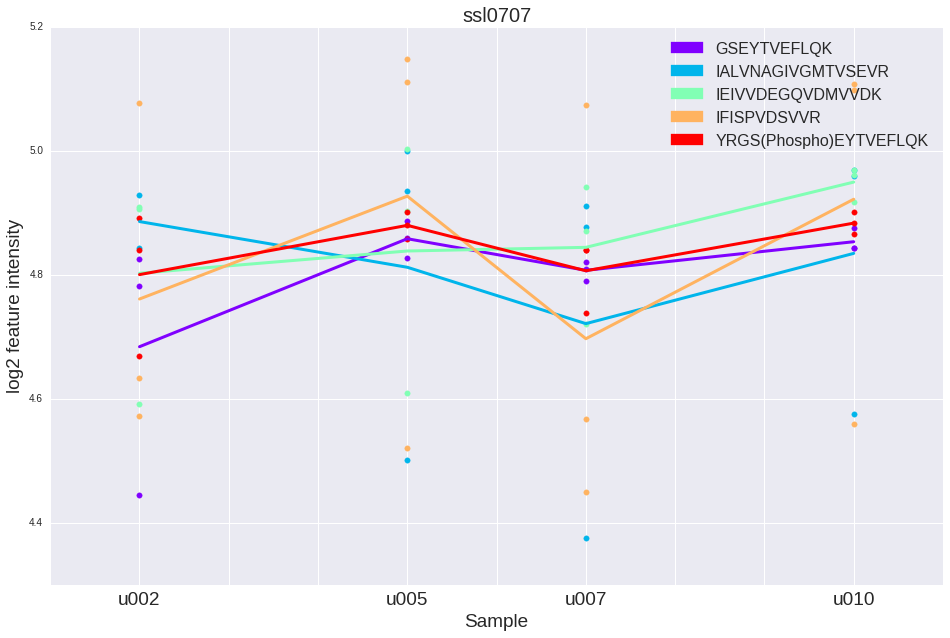

In [14]:
def abundance_plot(peptide_set):

    peptide_set_groups = peptide_set.groupby("peptide_0", group_keys=False)
    peptide_set = peptide_set_groups.apply(lambda x: x.ix[x.quality_cf.idxmax()])

    peptide_set[feature_cols] = peptide_set[feature_cols].apply(numpy.log2)

    for i in numpy.array(feature_cols).reshape(num_samples, num_replica):
        avg = peptide_set[i].mean(axis=1)
        peptide_set[i[0].split("_GM_")[1].split("_")[0]+"_mean"] = avg
    means = ["u002_mean", "u005_mean", "u007_mean", "u010_mean"]

    X = [1,2,3,4,5,6,7,8,9,10]
    x_labels = ['', 'u002', '', '', 'u005', '', 'u007', '', '',  'u010']
    nCols = len(X)
    color_patches = []
    fig, ax = plt.subplots(figsize=(16,10))
    color=iter(plt.cm.rainbow(numpy.linspace(0,1,len(peptide_set))))
    for i, row in peptide_set.iterrows():
        sequence = row.peptide_0
        Ys = row[feature_cols].values.reshape(4,3).T #for scatter
        nRows = Ys.shape[0]
        Xs=[2,5,7,10]*nRows
        c = next(color)
        ax.plot([2,5,7,10], row[means].values, "-", lw=3, color=c)
        ax.scatter(Xs, Ys, color=c, s=30)
        patch = mpatches.Patch(color=c, label=sequence)
        color_patches.append(patch)
    ax.set_ylabel("log2 feature intensity", fontsize=19)
    ax.set_xlabel("Sample", fontsize=19)
    ax.set_title("", fontsize=19)
    ax.set_xticks(X)
    ax.set_xticklabels(list(x_labels), fontsize=19)
    plt.legend(handles=color_patches, loc=0,   fontsize=16)
    plt.title(list(set(peptide_set.protein))[0], fontsize=20)
    plt.show()

abundance_plot(ssl0707_peptides)

### Get phosphopeptides (and corresponding phosphoproteins) with significant change in abundance

In [15]:
genes = "/home/vitalv/cyano_dataset_20161118/genes.txt"
genes_df = pandas.read_csv(genes, delimiter="\t", header=None)
genes_df.columns = ["DataSourceName", "geneID", "Chromosome", "Start", "Stop","Strand", "Description"]

data = pandas.merge(phospho_peptides, genes_df[["geneID","Description"]], left_on="protein", right_on="geneID", how='left')

for i in numpy.array(feature_cols).reshape(num_samples, num_replica):
	avg = data[i].mean(axis=1)
	data[i[1].split("_")[-2]+"_mean"] = avg

means = ["u002_mean", "u005_mean", "u007_mean", "u010_mean"]
data = data[["protein", "peptide_0", "Description"]+ feature_cols + means]

feature_cols[-3] = "Fusion_20161115_GM_u010_R1"

for index, row in data.iterrows():
	#Get df for each peptide with columns dependent_variable, factor_1 and factor_2:
	pep_df = pandas.DataFrame(columns=["dependent_variable", "group"])
	pep_df.group = [ s.split("_")[-2] for s in feature_cols ]
	pep_df.dependent_variable = row[feature_cols].values
	k = len(pandas.unique(pep_df.group))  # number of samples
	N = len(pep_df.values)  # samples times replica
	n = pep_df.groupby('group').size()[0] #num_replica
	DFbetween = k - 1
	DFwithin = N - k
	DFtotal = N - 1
	grand_mean = pep_df.dependent_variable.mean()
	SSbetween = sum( [ n * (pep_df[pep_df.group == g].dependent_variable.mean() - grand_mean)**2 for g in set(list(pep_df.group))] )
	sum_y_squared = sum([value**2 for value in pep_df['dependent_variable'].values if value > 0])
	SSwithin = sum_y_squared - sum(pep_df.groupby('group').sum()['dependent_variable']**2)/n
	SStotal = sum_y_squared - (pep_df['dependent_variable'].sum()**2)/N
	MSbetween = SSbetween/DFbetween
	MSwithin = SSwithin/DFwithin
	F = MSbetween/MSwithin
	p = stats.f.sf(F, DFbetween, DFwithin)
	data.loc[index, 'p_val'] = p

feature_cols[-3] = "Fusion_20161115_GM_u010_R1_2"
phospho_peptides_anova = data.sort_values(by="p_val")[["protein", "peptide_0", "Description"] + feature_cols + ["p_val"]]
phospho_peptides_anova = phospho_peptides_anova[phospho_peptides_anova.p_val < 0.05]
phospho_proteins_anova = list(phospho_peptides_anova.protein)
print "Phosphoproteins with significantly changing peptides: %s" % phospho_proteins_anova

Phosphoproteins with significantly changing peptides: ['slr1950', 'sll6053', 'slr0772', 'slr1859']


#### Find sibling peptides for phospho_peptides_anova (belonging to each protein in phospho_proteins_anova)

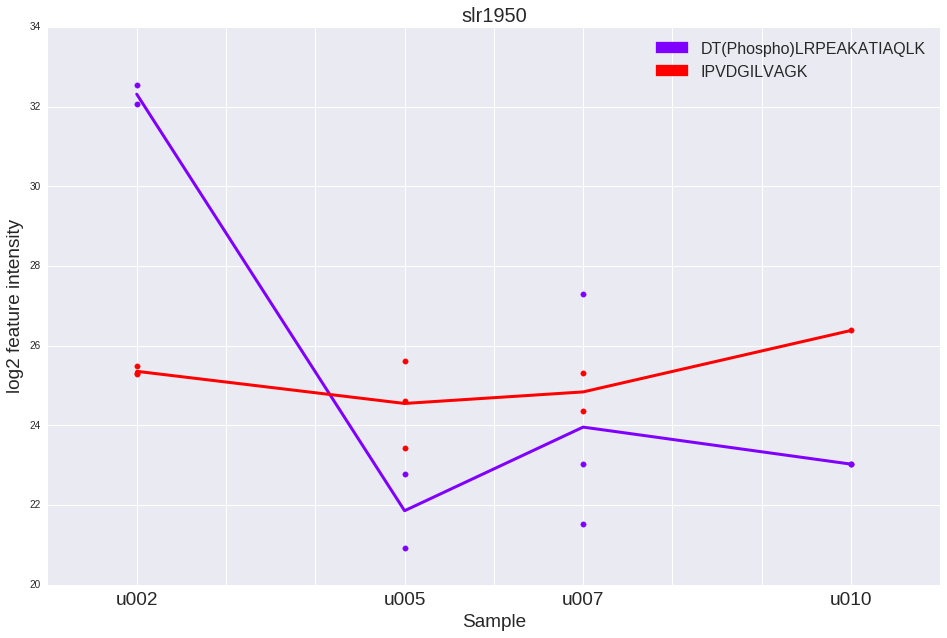

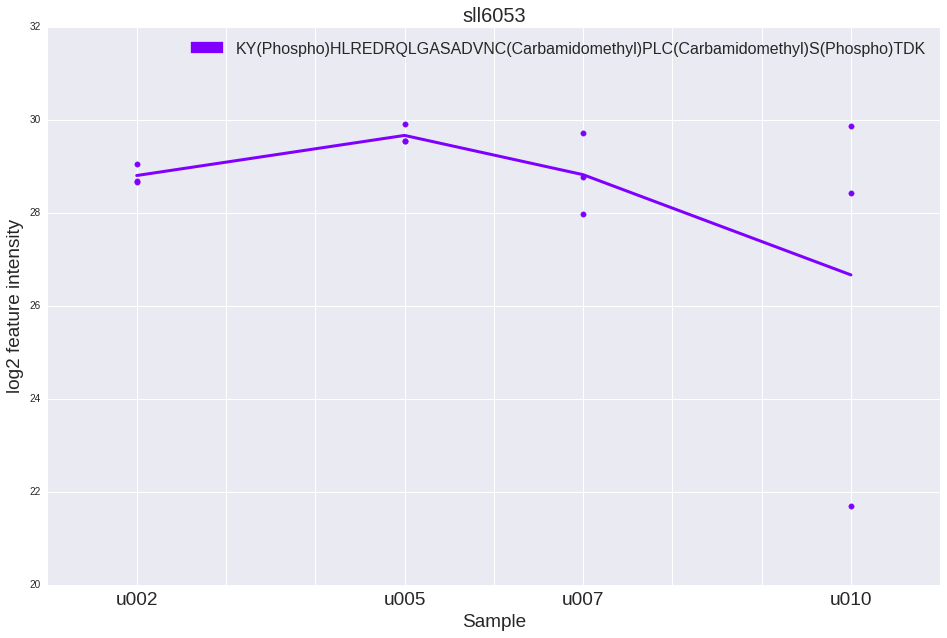

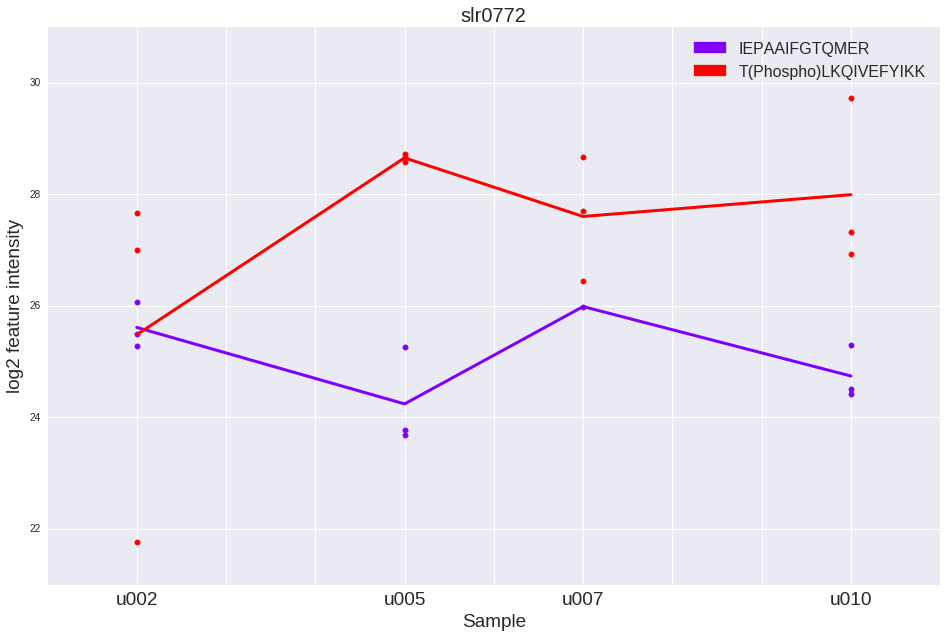

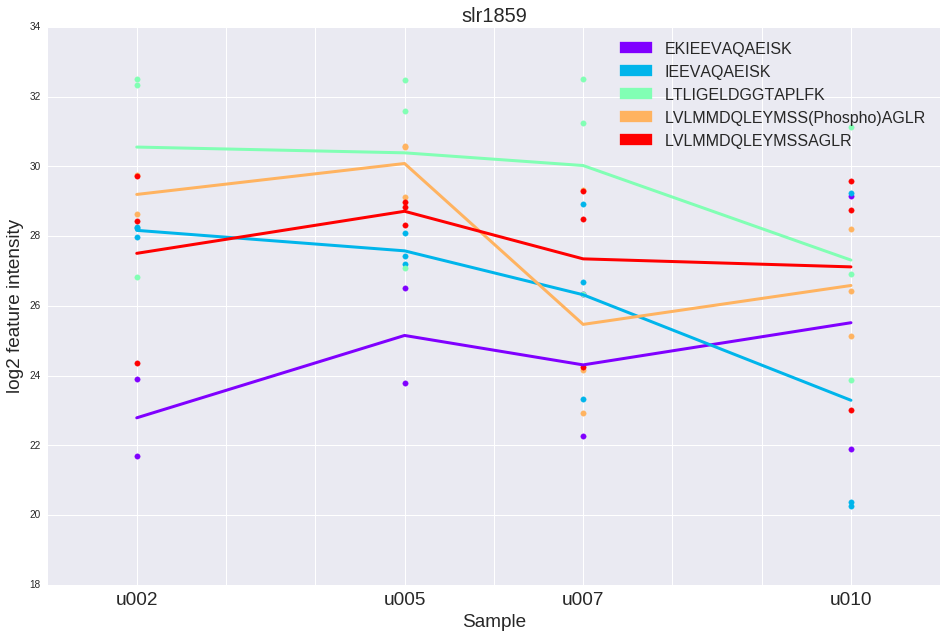

In [16]:
for p in phospho_proteins_anova:
	pep_set = cons[cons.protein == p]
	abundance_plot(pep_set)

### mod A
Ran mod A open modifications @ rackham.   
One sh file with one sbatch command to run each of the bunch of sh files:  

java -Xmx2000M -jar /home/vitalv/moda_v1.51/moda_v1.51.jar -i /proj/snic2016-7-\
94/cyano_dataset_20161118/modA/params_synecho_002_R1.moda -o /proj/snic2016-7-9\
4/cyano_dataset_20161118/modA/Fusion_20161115_GM_u002_R1.txt  




In [17]:
modA_folder = "/home/vitalv/cyano_dataset_20161118/modA"
modA_out_files = [f for f in modA_folder if f.endswith(".txt")]


#### FDR filtering.   
 Either run anal_modA :  
 java -jar anal_moda.jar  
 (Note I need a decoy prefix (-d) but my database and search results decoys have suffix _rev)  
 
 Or use percolator -filtered files (Matthew's script: modA output -> Percolator)  

In [18]:
#Prepare files to run anal_modA: (replace _rev suffix with R_ prefix)
for file_name in modA_out_files:
	decoy_prefix(file_name)

def decoy_prefix(file_name):
	with open("_" + file_name,'w') as new_file:
		with open(file_name) as old_file:
			for line in old_file:
				if "_rev" in line:
					new_file.write(line.replace(line.split("\t")[-2], "R_" + line.split("\t")[-2].replace("_rev", "")))
				else:
					new_file.write(line)

#Then run anal_modA -d R_ 0.01 bla bla

#### Read PTM matrix from anal_modA output:

In [32]:
ptm_files = [f for f in os.listdir("/home/vitalv/cyano_dataset_20161118/modA") if f.endswith("ptm.txt")]
ptm_df_dict = {}
for ptm_file in ptm_files:
	s = ptm_file.split("_GM_")[1].split(".")[0]
	ptm_df = pandas.read_csv(os.path.join("/home/vitalv/cyano_dataset_20161118/modA", ptm_file), sep="\t")
	ptm_df.rename(columns={' ':'mshift'}, inplace=True) 
	ptm_df_dict[s] = ptm_df
columns_to_sum = ptm_df.columns[1:]
ptm_df_list = ptm_df_dict.values()
combined_ptms = pandas.concat(ptm_df_list).groupby(["mshift"], as_index=False)[columns_to_sum].sum()
combined_ptms.sort_values(by="Sum", ascending=False, inplace=True)
top_ptms = combined_ptms.head()

In [44]:
ptm_files_b = [f for f in os.listdir("/home/vitalv/cyano_dataset_20161118/modA/bullseye") if f.endswith("ptm.txt")]
ptm_df_dict_b = {}
for ptm_file_b in ptm_files_b:
	s = ptm_file.split("_GM_")[1].split(".")[0]
	ptm_df_b = pandas.read_csv(os.path.join("/home/vitalv/cyano_dataset_20161118/modA/bullseye", ptm_file_b), sep="\t")
	ptm_df_b.rename(columns={' ':'mshift'}, inplace=True) 
	ptm_df_dict_b[s] = ptm_df_b
columns_to_sum = ptm_df_b.columns[1:]
ptm_df_list_b = ptm_df_dict_b.values()
combined_ptms_b = pandas.concat(ptm_df_list_b).groupby(["mshift"], as_index=False)[columns_to_sum].sum()
combined_ptms_b.sort_values(by="Sum", ascending=False, inplace=True)
top_ptms_b = combined_ptms_b.head()


#### Get matrix with combined frequencies for ALL ms runs

In [45]:
columns_to_sum = ptm_df.columns[1:]
ptm_df_list = ptm_df_dict.values()
combined_ptms = pandas.concat(ptm_df_list).groupby(["mshift"], as_index=False)[columns_to_sum].sum()
combined_ptms.sort_values(by="Sum", ascending=False, inplace=True)
top_ptms = combined_ptms.head()

#### Get histogram for the most abundant modifications

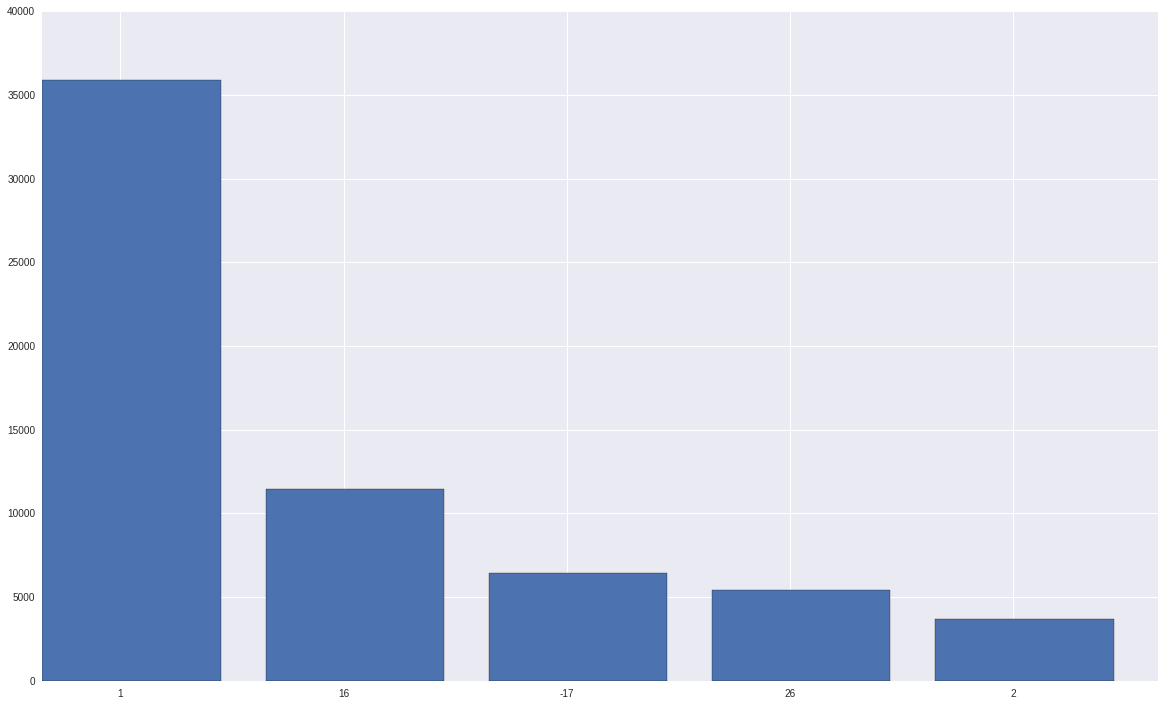

In [46]:
ind = numpy.arange(1, len(top_ptms)+1)
width = 0.35# the width of the bars
#fig, ax = plt.subplots()
tick_labels = top_ptms.mshift
plt.bar(ind, top_ptms.Sum)
plt.xticks(ind+width, tick_labels)
plt.show()

#### Now focus on Phosphorylation and Acetylation

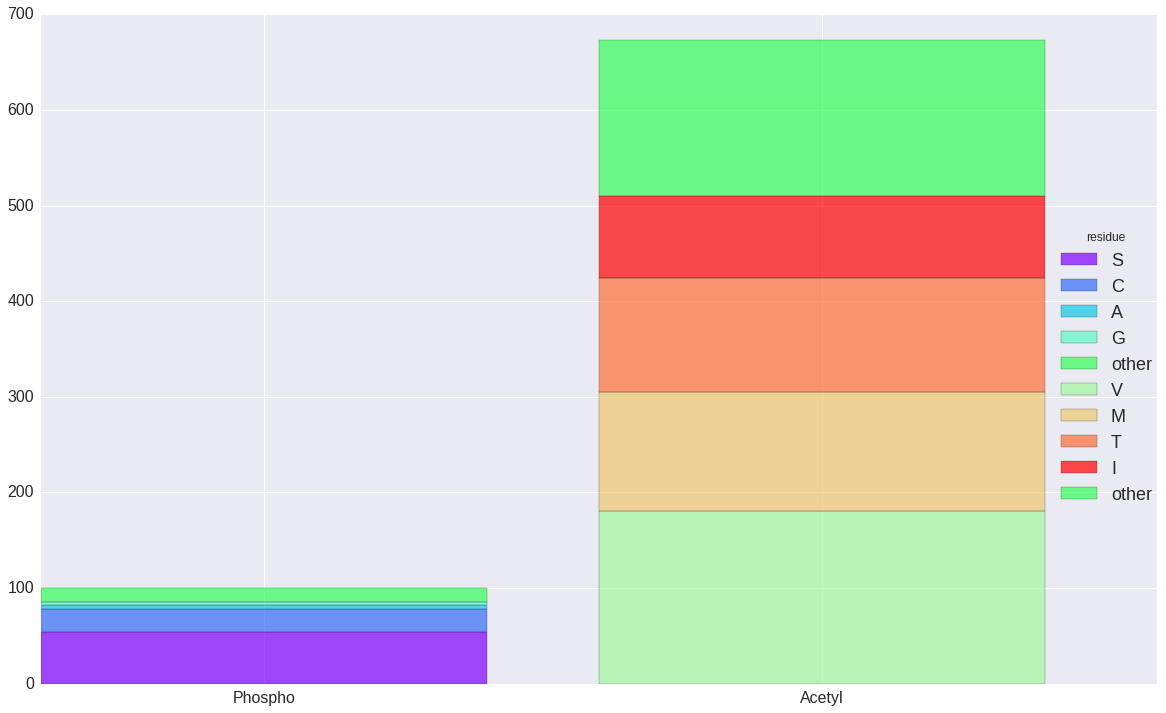

In [47]:
import matplotlib.cm as cm
import operator

aas = list("ACDEFGHIKLMNPQRSTVWY")

phospho_freq = combined_ptms[combined_ptms.mshift == 80][aas]
phospho_residues = [c for c in list(phospho_freq.columns) if int(phospho_freq[c]) > 0]
phospho_residues_dict = phospho_freq[phospho_residues].to_dict('index').values()[0]
phospho_residues_freq = sorted(phospho_residues_dict.items(), key=operator.itemgetter(1), reverse=True)
phospho_top_freq = phospho_residues_freq[0:4]

acetyl_freq = combined_ptms[combined_ptms.mshift == 42][aas]
acetyl_residues = [c for c in list(acetyl_freq.columns) if int(acetyl_freq[c]) > 0]
acetyl_residues_dict = acetyl_freq[acetyl_residues].to_dict('index').values()[0]
acetyl_residues_freq = sorted(acetyl_residues_dict.items(), key=operator.itemgetter(1), reverse=True)
acetyl_top_freq = acetyl_residues_freq[0:4]

other_freq = (phospho_residues_freq[4:-1], acetyl_residues_freq[4:-1])

color=iter(plt.cm.rainbow(numpy.linspace(0,1,len(phospho_top_freq+acetyl_top_freq))))
top_freq = (phospho_top_freq, acetyl_top_freq)
for pa in range(len(top_freq)): #(0,1)
	for i in range(len(top_freq[pa])): #(0,1,2,3,4)
		offset = sum([c[1] for c in top_freq[pa][0:i]])
		plt.bar(pa+1, top_freq[pa][i][1], width=0.80, bottom=offset, label=top_freq[pa][i][0], alpha=0.7, color=next(color))
	sum_top = sum([c[1] for c in top_freq[pa]])
	sum_other = sum([c[1] for c in other_freq[pa]])
	plt.bar(pa+1, sum_other, width=0.80, bottom=sum_top, label='other', alpha=0.7, color='#33FF57')

plt.yticks(fontsize=16)
plt.xticks([1.4,2.4], ["Phospho", "Acetyl"], fontsize=16)
legend = plt.legend(bbox_to_anchor=(1.01,0.7), title="residue", prop={'size':18})
plt.rcParams["figure.figsize"] = (20,12)

weird results from the modA & anal_modA analysis like phosphorylations at C and other things..
read results from percolator:

In [48]:
modA_perc = pandas.read_csv("/home/vitalv/cyano_dataset_20161118/modA/percolator/Fusion.psms.txt", sep="\t")

#modA_r1_id = pandas.read_csv("/home/vitalv/cyano_dataset_20161118/modA/bullseye/Fusion_20161115_GM_u002_R1.id.txt", sep="\t")
#modA_r1_id_ptms = modA_r1_id[modA_r1_id.Peptide.str.contains("[+-]")]

modA_perc = modA_perc[modA_perc["q-value"] < 0.01]

modA_perc_ptms = modA_perc[modA_perc["peptide"].str.contains("\[")]



#### NOTE: Should I count PTMs at PSM level or a peptide level?
That is, if I see two peptides:  

PEPT[80]IDE,  
PEPT[80]IDE,   

Should I count those as two phosphorylations at T? Or just one?

I think it should be just one: Group percolator results by 'peptide' :
modA_perc_ptms_peptides = modA_perc_ptms.groupby('peptide').size().index


In [49]:
modA_perc_ptms_peptides = modA_perc_ptms.groupby('peptide').size().index

#### But NO,
in the results from modA the matrix I use to get the sum of the total number of PTMs (over all runs) (files .ptm.txt) is generated from summing PSM-level PTMs:

SEE Fusion_ 002_R1.id.txt:  

#484 R.GDALGN-23LLR.Q  
#485 R.GDALGN-23LLR.Q  

They are two distinct PTMs in file id.txt. AND in the equivalent ptm.txt I can see there are two -23 PTMs at N !


In [50]:
#get top ptms from percolator results: (PSM-level PTMs)
#first get ptms frequencies:
all_ptms = [] #all_ptms_psms, all_ptms_psms
for peptide in list(modA_perc_ptms["peptide"]):
	all_ptms += re.findall("\[\d+\]", peptide)

In [51]:
all_ptms_peptides = [] #(Peptide-level PTMs)
for peptide in modA_perc_ptms_peptides:
	all_ptms_peptides += re.findall("\[\d+\]", peptide)


In [52]:
#get top ptms frequencies (PSM-level PTMs)
import operator
all_ptms_freq = sorted(collections.Counter(all_ptms).items(), key=operator.itemgetter(1))
all_ptms_freq.reverse()


### compare top_PTMs from modA, top_PTMs from modA+bullseye and  top_PTMs from modA+percolator

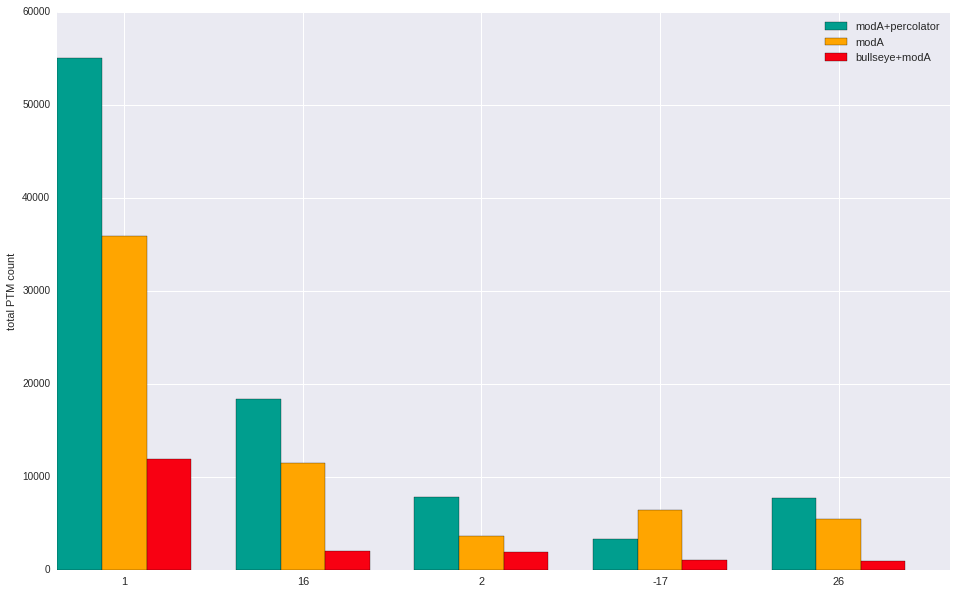

In [53]:
#top_PTMs from modA+percolator:
top_ptms_p = all_ptms_freq[0:6]
#top_PTMs from modA:
top_ptms_m = zip(top_ptms["mshift"], top_ptms.Sum)
#top_PTMs from modA+bullseye:
top_ptms_b = zip(top_ptms_b["mshift"], top_ptms_b.Sum)


#modA+bullseye top modifications:
#[(1, 11910), (16, 1995), (2, 1863), (-17, 1057), (26, 908)]

#modA top modificaitons:
#[(1, 35880), (16, 11465), (-17, 6434), (26, 5439), (2, 3676)]

#modA+percolator top modifications
#[('[1]', 55028), ('[16]', 18381), ('[2]', 7844), ('[26]', 7677), ('[28]', 5476), ('[17]', 3352)]

				#1	 #16	#2	 #-17  #26	
top_ptms_b = [11910, 1995, 1863, 1057, 908]
top_ptms_m = [35880, 11465, 3676, 6434, 5439]
top_ptms_p = [55028, 18381, 7844, 3352, 7677] #counting PSM PTMs as different PTMs
#top_ptms_p = [19874, 4295, 7844, 3352, 7677] #collapsing PSMs corresponding to same peptide sequence


ind = numpy.arange(len(top_ptms_m))  # the x locations for the groups
width = 0.25# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,10))
#categories_anova, categories_identified, categories_genome = [], [], []
tick_labels = ["1", "16", "2", "-17", "26"]
rects1 = ax.bar(ind , top_ptms_p, width, color='#009E8E')
rects2 = ax.bar(ind + width, top_ptms_m, width, color='#FFA500')
rects3 = ax.bar(ind + 2*width, top_ptms_b, width, color='#F80012')
ax.set_ylabel("total PTM count", fontsize=11)
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels, fontsize=11)
ax.legend((rects1[0], rects2[0], rects3[0]), ('modA+percolator', 'modA', 'bullseye+modA'), fontsize=11)
plt.xticks(ind+1.5*width, tick_labels)
plt.show()
